In [1]:
import pyarrow.parquet as pq
import numpy as np
import glob

In [2]:
import numpy as np
np.random.seed(0)
import pyarrow as pa
import pyarrow.parquet as pq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import *

import time
import os, glob
# Specify which gpuid to use
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)

In [3]:
import matplotlib.pyplot as plt 
from  matplotlib.ticker import MultipleLocator
from matplotlib.colors import LogNorm

In [4]:
class ParquetDataset(Dataset):
    '''
    Define Dataset class for "good" samples.
    Occ vs PU correction to be applied here to obtain a normalized occupancy as a fn of PU
    '''
    def __init__(self, filename):
        self.parquet = pq.ParquetFile(filename)
        #self.cols = None # read all columns
        self.cols = ['EBOccupancyTask_EBOT_digi_occupancy.list.item.list.item','PU']
    def __getitem__(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data['EBOccupancyTask_EBOT_digi_occupancy'] = np.float32(data['EBOccupancyTask_EBOT_digi_occupancy'][0]).reshape(-1,34,72)
        data['PU']= np.float32(data['PU'][0])     
        data['index'] = index
       
        return (data)

    def __len__(self):
        return self.parquet.num_row_groups

In [5]:
#load input data
input_runs= glob.glob('Good_parquet/500ev_ECALDQM_run*.parquet')
dset_good = ConcatDataset([ParquetDataset('%s'%r) for r in input_runs])


In [6]:
Occ_list18=[]
PU_list18=[]

for i in range(len(dset_good)):
    EBocc = dset_good[i]['EBOccupancyTask_EBOT_digi_occupancy']
    pu = dset_good[i]['PU']
    Occ_list18.append(np.sum(EBocc))
    PU_list18.append(pu)

In [7]:
PU_list18 = np.array(PU_list18)
Occ_list18 = np.array(Occ_list18)

In [8]:
print(len(Occ_list18), len(PU_list18))

101936 101936


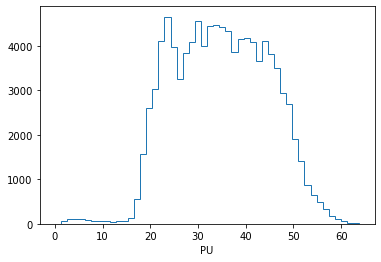

In [9]:
#PU 
plt.hist(PU_list18, histtype='step', bins=50)
plt.xlabel('PU')
plt.show()


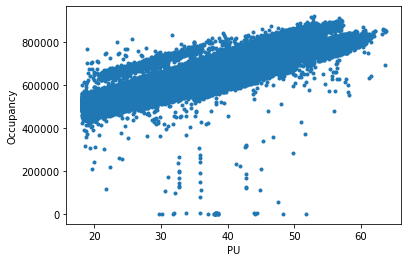

In [10]:
# Occ vs PU #only look at PU > 18.
plt.plot(PU_list18[PU_list18>18.],Occ_list18[PU_list18>18.],'.')
plt.xlabel('PU')
plt.ylabel('Occupancy')
plt.show()

In [11]:
#only look at PU > 18.
cut_PU_list18= PU_list18[PU_list18>18.]
cut_Occ_list18= Occ_list18[PU_list18> 18.]

print(cut_PU_list18.shape, cut_Occ_list18.shape)

fitval=np.polyfit(cut_PU_list18,cut_Occ_list18,1)
print(fitval)
np.savetxt('PU_corr_EB_2018.txt', fitval)

(100303,) (100303,)
[  8613.74931694 354776.97562279]


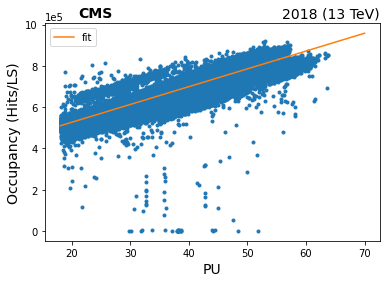

In [12]:
#Plot Occ vs PU
x=np.linspace(18,70,num=200000)
p18=np.poly1d(fitval)

plt.plot(cut_PU_list18,cut_Occ_list18,'.')
plt.plot(x,p18(x),'-', label='fit')
plt.xlabel('PU',size='14')
plt.ylabel('Occupancy (Hits/LS)', size='14')
plt.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
plt.rc('xtick', labelsize='12')
plt.rc('ytick', labelsize='12')
plt.title('CMS', fontweight='bold',x=0.15, y=1.0, size=14)
plt.title('2018 (13 TeV)',loc='right', size=14)
plt.legend()
#plt.savefig('NewPlots/all2018_OccvsPU_cut_cmslabel.png', bbox_inches='tight')
plt.show()



In [13]:
#Apply the fit values to occupancy

Nlen=len(cut_Occ_list18)
occ_postfit = []
for i in range(Nlen):
        data = cut_Occ_list18[i]
        pu=cut_PU_list18[i]
        occ_pfit = data/(fitval[0]*pu + fitval[1]) 
        occ_postfit.append(occ_pfit)
        


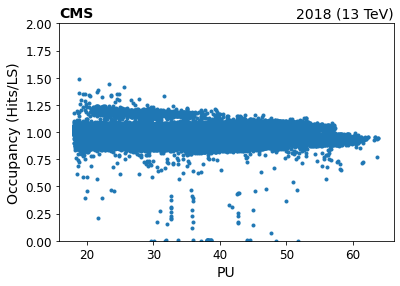

In [14]:
plt.plot(cut_PU_list18,occ_postfit,'.')
plt.ylabel('Occupancy (Hits/LS)',size='14')
plt.xlabel('PU',size='14')
plt.rc('xtick', labelsize='12')
plt.rc('ytick', labelsize='12')
plt.title('CMS', fontweight='bold',loc='left', size=14)
plt.title('2018 (13 TeV)',loc='right', size=14)
plt.ylim(0,2.0)
#plt.savefig('NewPlots/all2018_fitOcc_vsPU_cut_cmslabel.png',bbox_inches='tight')
plt.show()

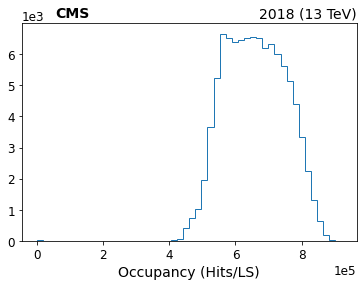

In [15]:
#2018 occ before fit
plt.hist(cut_Occ_list18, histtype='step', bins=50)
#plt.ylim(0,40000)
plt.xlabel('Occupancy (Hits/LS)',size='14')
plt.rc('xtick', labelsize='12')
plt.rc('ytick', labelsize='12')
plt.title('CMS', fontweight='bold',x=0.15,y=1.,size=14)
plt.title('2018 (13 TeV)',loc='right', size=14)
plt.ticklabel_format(axis="x", style="sci", scilimits=(1,5))
plt.ticklabel_format(axis="y", style="sci", scilimits=(4,5))
#plt.savefig('NewPlots/all2018_Occ_1d_beforefit_cmslabel.png',bbox_inches='tight')
plt.show()

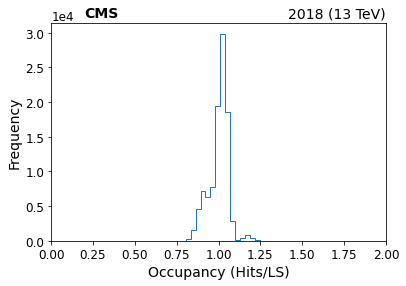

In [16]:
#2018 occ after fit 
plt.hist(np.array(occ_postfit), histtype='step', bins=50)
plt.xlim(0,2.0)
plt.xlabel('Occupancy (Hits/LS)',size=14)
plt.ylabel('Frequency',size=14)
plt.rc('xtick', labelsize='12')
plt.rc('ytick', labelsize='12')
plt.title('CMS', fontweight='bold',x=0.15,y=1., size=14)
plt.title('2018 (13 TeV)',loc='right', size=14)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,4))
#plt.savefig('NewPlots/all2018_Occ_1d_afterfit_cmslabel.png',bbox_inches='tight')
plt.show()